## Fun with Gene Vectors

In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# gene2vec and somatic functions
from config import TCGA, GENE2VEC_DIR
from utils import *
from gene2vec import *
from cluster import *
from somatic import *
from dataset import generate_dataset

---
#### Word Vector Experimentation
<a id="2d"></a>

For each sample, now want to encode gene2vec embeddings as a prior on mutation data.
- Evaluate separation difference between gene2vec training iterations (checkpoints) (iter_1, iter_5, iter_10)
- Evaluate separation with dimension (16, 128, 1024)
- Evaluate Scree plot (break down of PC's) across dimensions

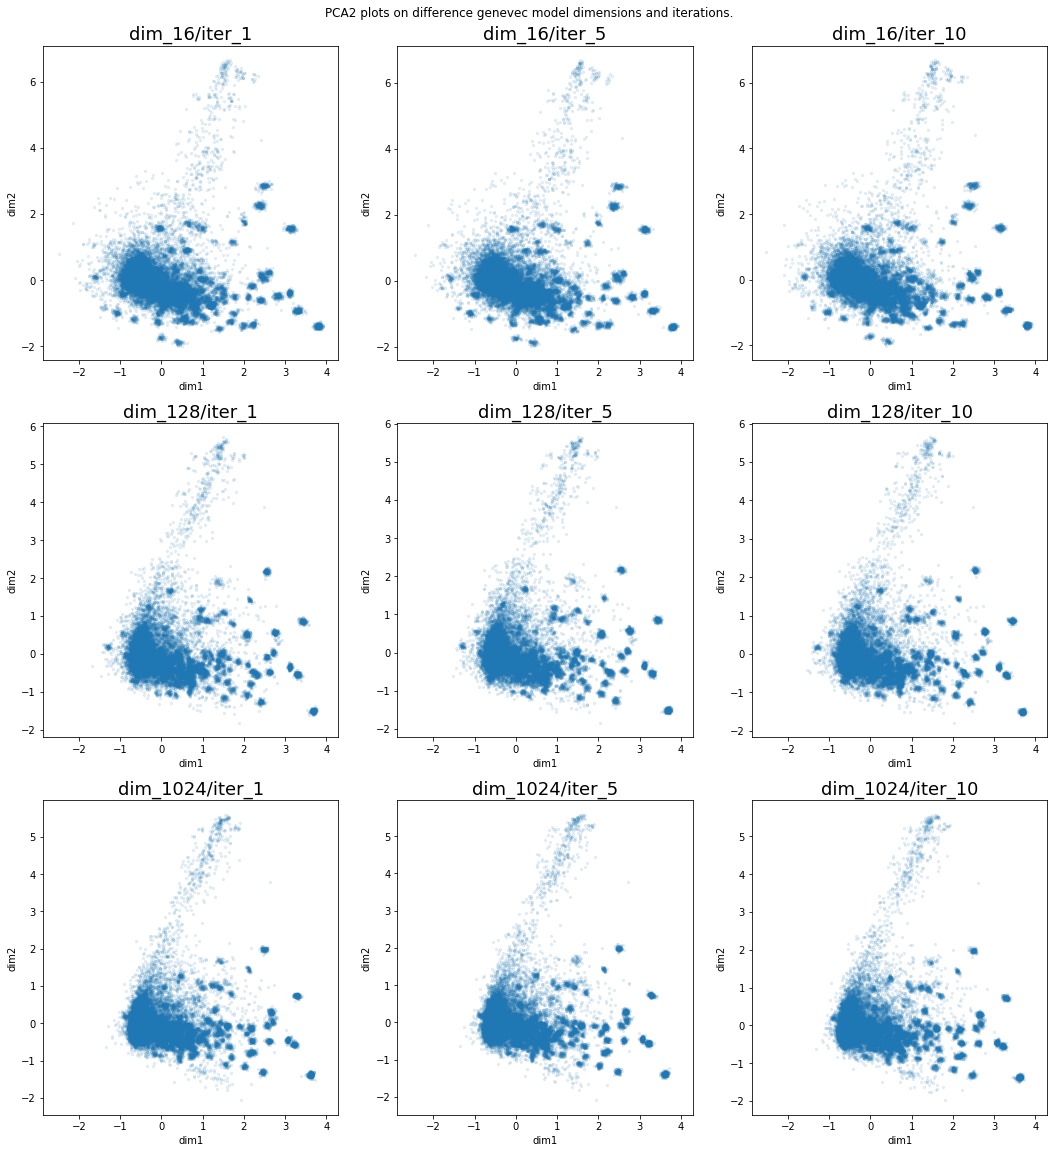

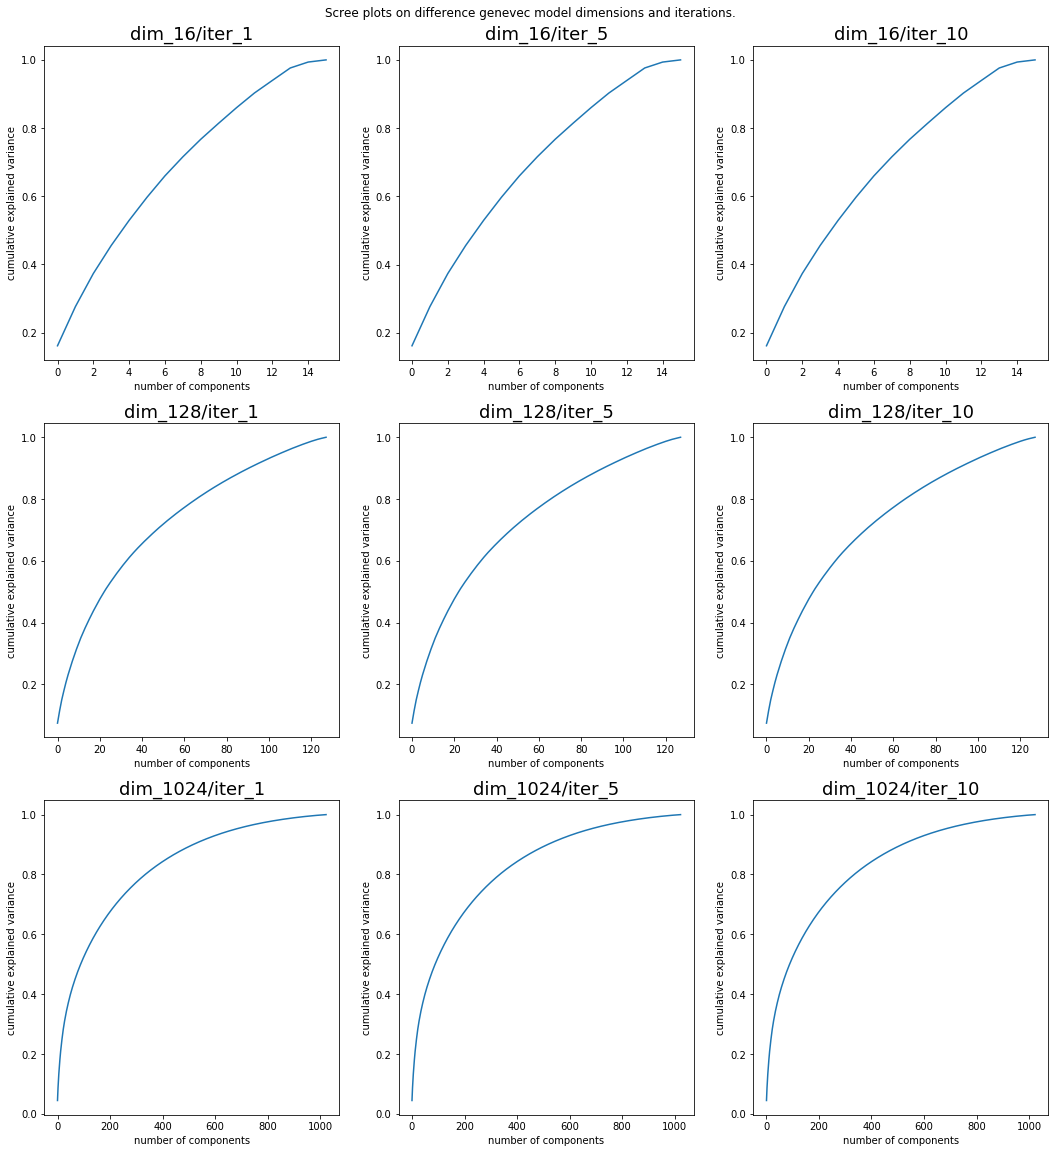

In [2]:
vis_pca2_genevec()
vis_scree_genevec()

---
#### Clustering Evaluation
<a id="cluster"></a>

Would like to audit available clustering techniques and visualise PCA2 to establish best technique to cluster/order genes. Clustering algorithms are taken from SKLearn and those available to be evaluated are:
- MiniBatchKMeans
- SpectralClustering
- Ward
- DBSCAN
- OPTICS
- Birch
- GaussianMixture

To do:
- Add non-linear kernel PCA
- tSNE on PCA
- Compare with VAE latent space
- [Beta TC-VAE](https://arxiv.org/pdf/1802.04942.pdf)
- [Glow VAE](https://openai.com/blog/glow/)

CPU times: user 24min 19s, sys: 25min 46s, total: 50min 5s
Wall time: 5min 26s


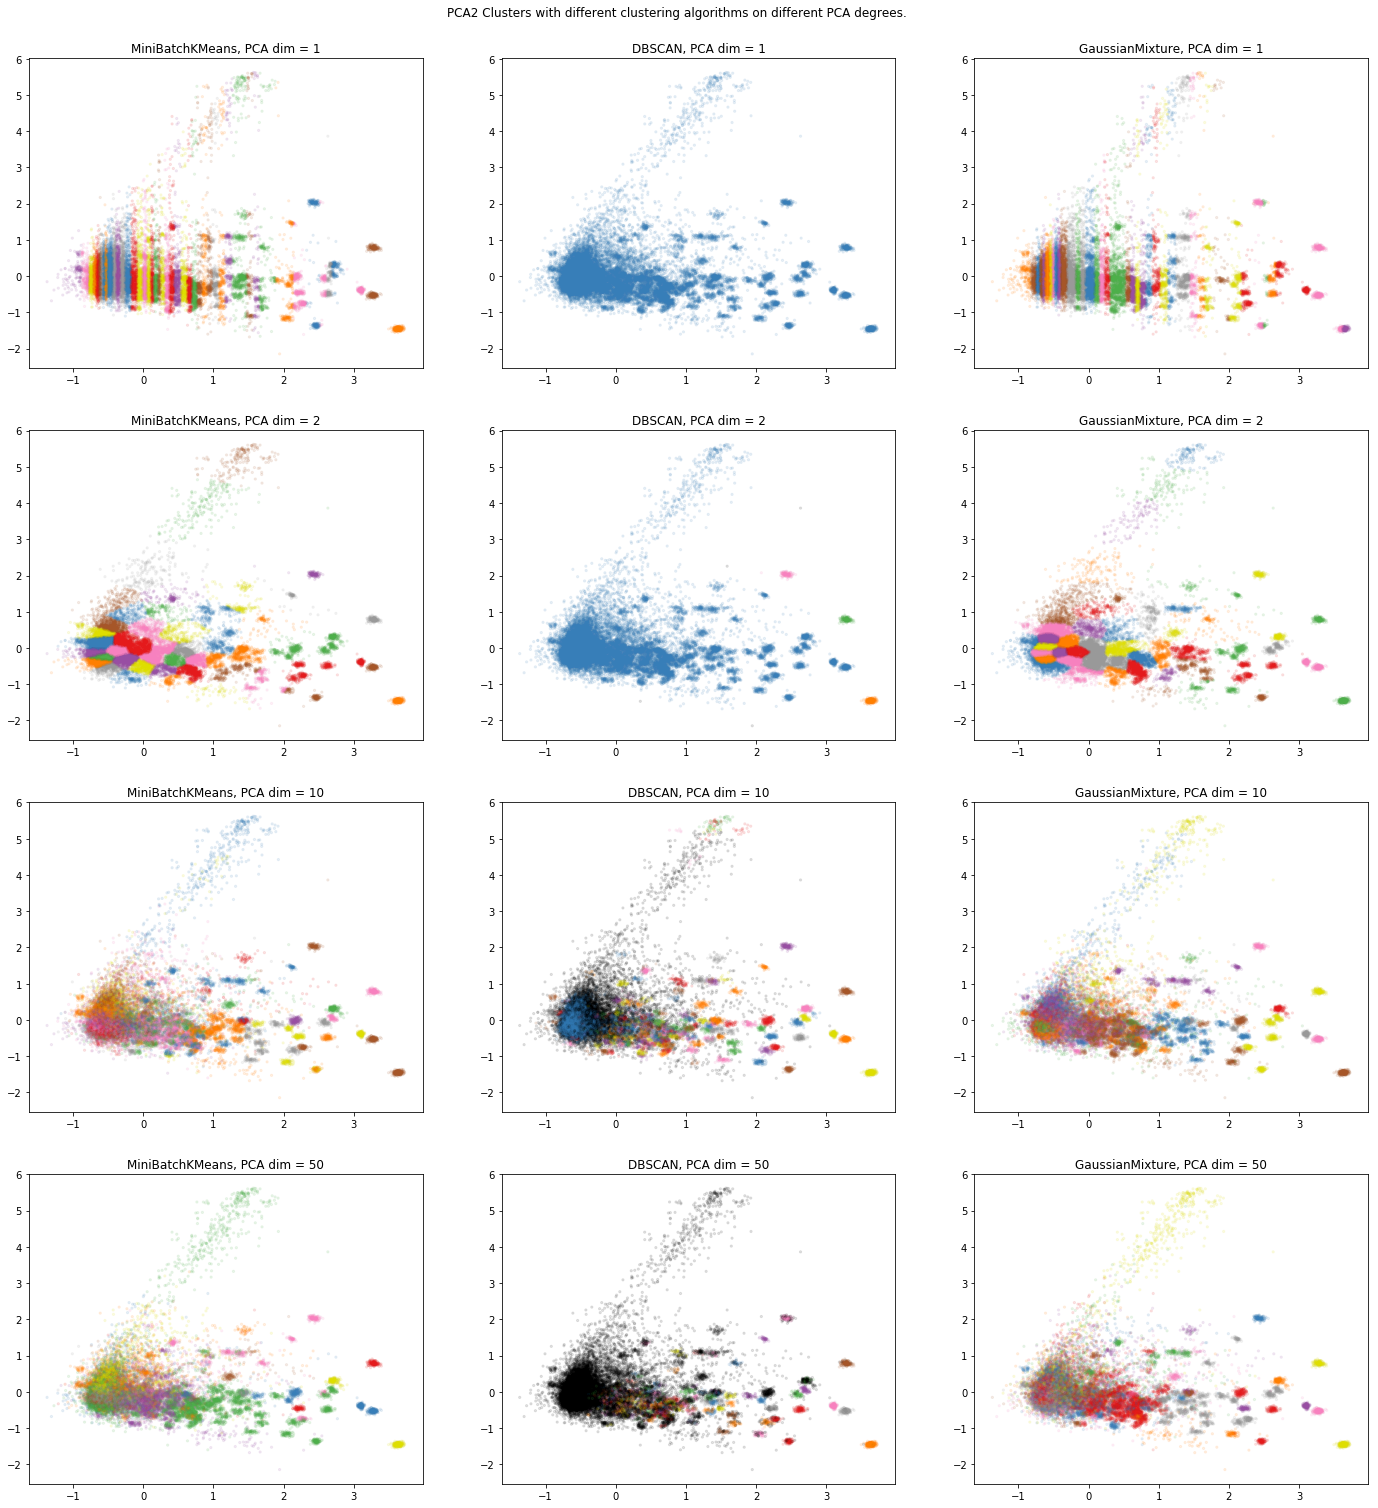

In [3]:
%%time
# load data
dim = 256
filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(dim)
wv, vocab = load_embeddings(filename)
X = wv
    
pca_degree=[1, 2, 10, 50]
selected_algos = ['MiniBatchKMeans',
                  'DBSCAN',
                  'GaussianMixture']
vis_pca2_clusters(X, pca_degree, selected_algos, n_clusters=50)

---
#### Load and preprocess somatic mutations from [TCGA in BigQuery](https://bigquery.cloud.google.com/table/isb-cgc:TCGA_hg38_data_v0.Somatic_Mutation?pli=1)
<a id="tcga"></a>

- Subset query has already been completed in BQ and saved to Google Cloud Storage
- In absence of MutSigCV results use list of 459 driver genes from [Intogen](https://www.intogen.org/search)

In [4]:
# raw data
tcga_raw = pd.read_csv(TCGA)

# empirical dim reduction
df_proc1 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(filter_intogen_drivers))

# statistical dim reductions
df_proc2 = (tcga_raw.pipe(process_labels)
                    .pipe(filter_variants)
                    .pipe(drop_low_mut_count, 'Hugo_Symbol', 200))     # naïvely remove very genes with few mutations as noise

# visualise_distributions(tcga_raw, 'Raw TCGA Data')
# visualise_distributions(df_proc1, 'Empirical Dim Reduction')
# visualise_distributions(df_proc2, 'Statistical Dim Reduction')

# Get processed dataframes ready for training
df_X1 = (df_proc1.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_X2 = (df_proc2.pipe(dedup_and_get_variant_count)
                 .pipe(reshape_pivot))

df_y1 = (df_proc1.pipe(get_label_df, df_X1))
df_y2 = (df_proc2.pipe(get_label_df, df_X2))

del df_proc1, df_proc2
freememory()

---
#### Visualise Clustering on subset of filtered genes
<a id="subset"></a>

- DF_X1 is 'empirical' gene selection using intogen list
- DF_X2 is 'statistical' gene selection

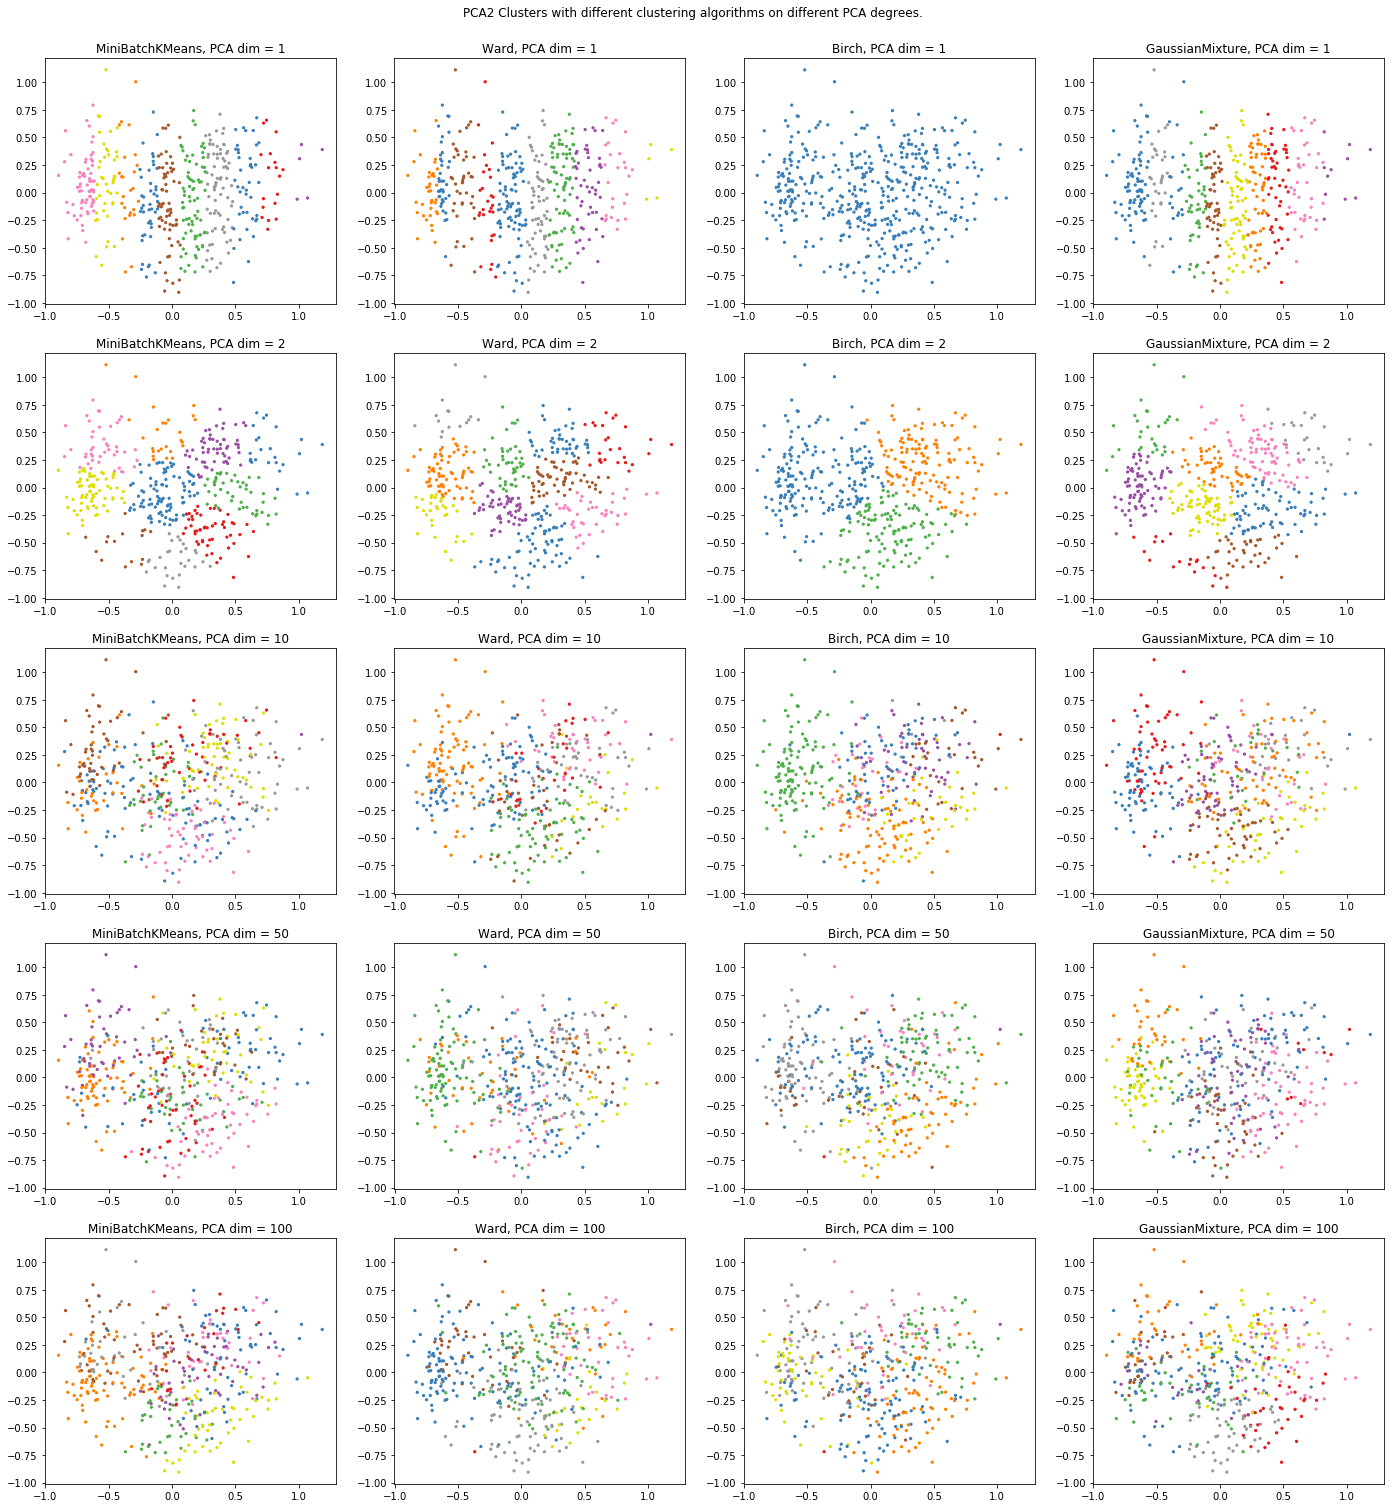

In [5]:
df_somatic = convert_to_onehot(df_X1)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(df_somatic, df_genevec)
merge1 = df_somatic[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

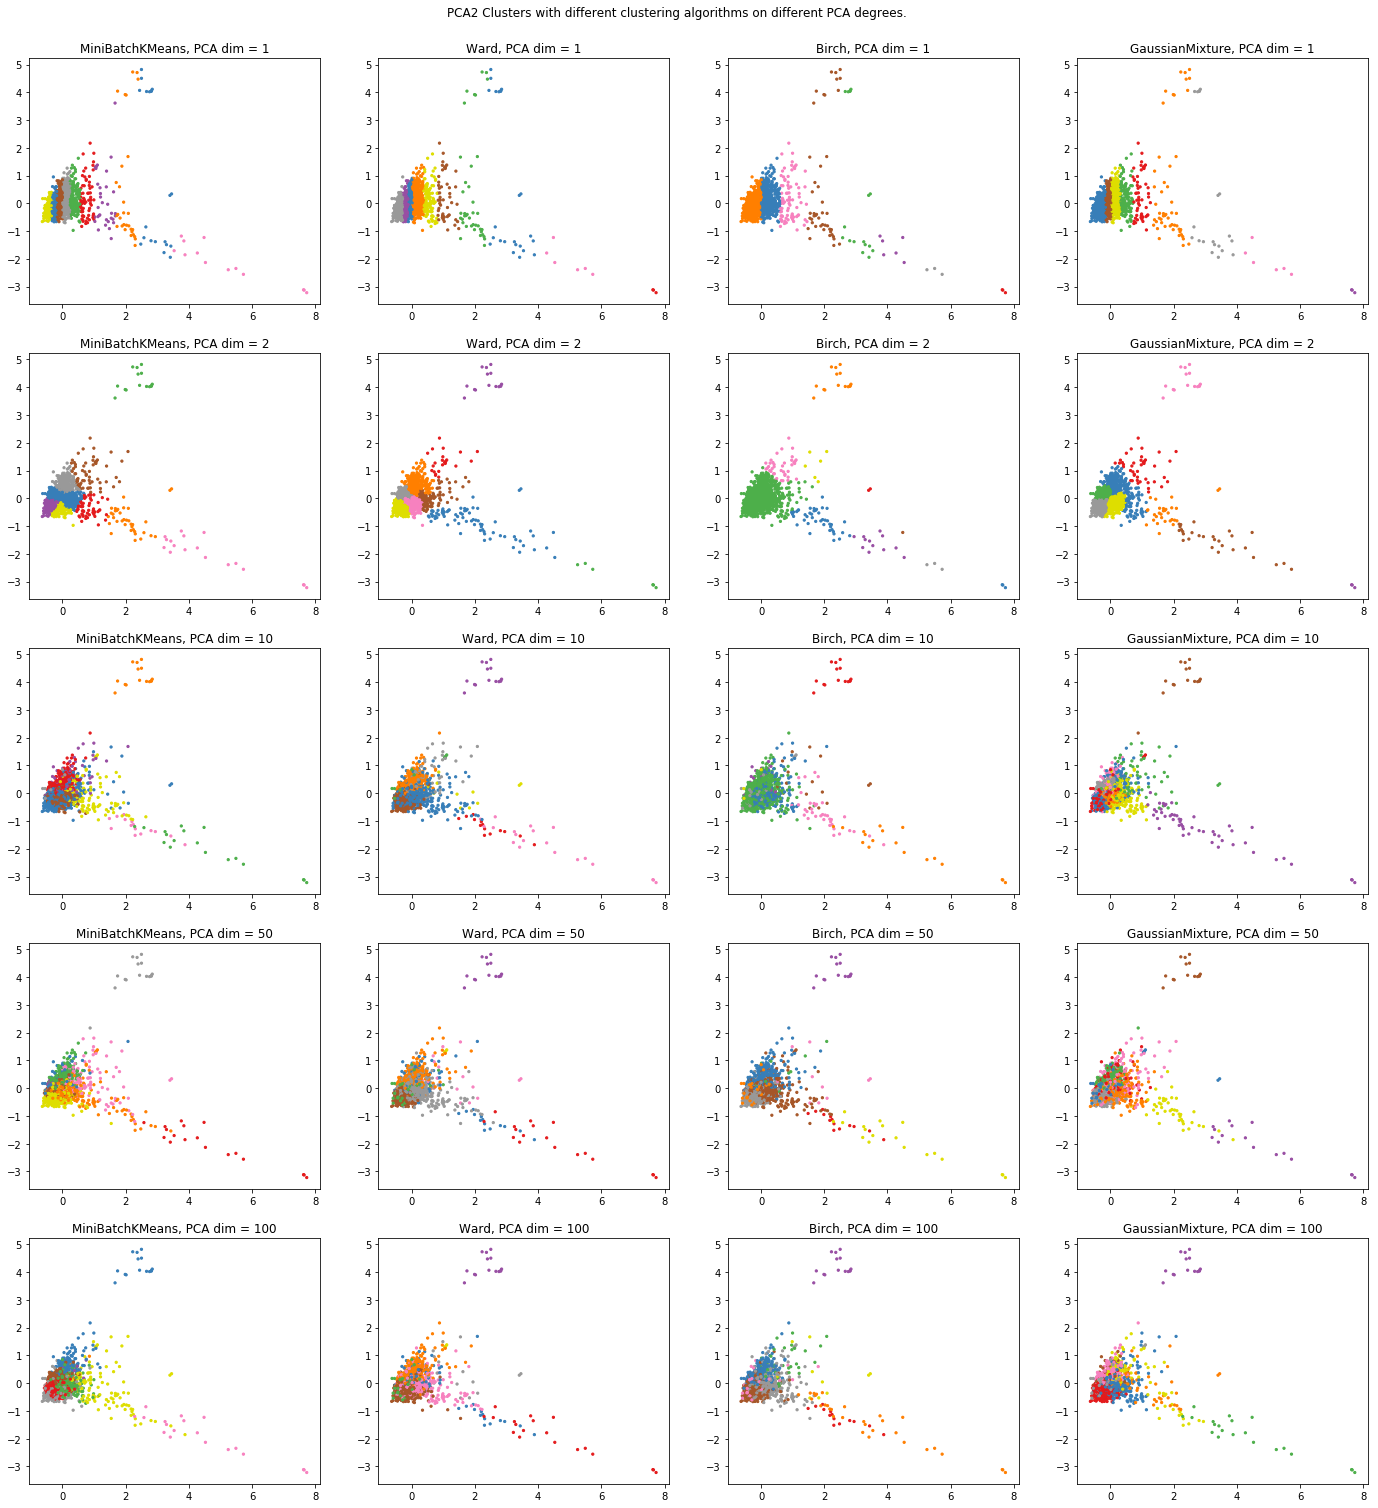

In [6]:
test = convert_to_onehot(df_X2)
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
genes = gene_intersection(test, df_genevec)
merge1 = test[genes]
merge2 = df_genevec[genes]

pca_degree=[1, 2, 10, 50, 100]
selected_algos = ['MiniBatchKMeans',
                  'Ward',
                  'Birch',
                  'GaussianMixture']
vis_pca2_clusters(merge2.values.transpose(), pca_degree, selected_algos, alpha=1, n_clusters=10)

---
#### Image Evaluation
<a id="image"></a>

Visual comparison of resulting images for a particular sample. Looking at different parameter combinations.
Explore following parameters on images:
- Clustering algorithm for sorting 
    - {GaussianMixture, DBScan, 1D-PCA} vs dimensionality of GeneVectors {64, 256, 512}
    - [Spectral Biclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py) or [Spectral Coclustering](https://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_coclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-coclustering-py)
- Normalisation on image matrix, resulting distribution on images and images themselves
    - 0,1 normalise on non-zero values only
    - Take absolute value only
- [Colour map](https://matplotlib.org/examples/color/colormaps_reference.html)
    - Favour best visual artefacts
    - For values symmetric around zero, use diverging colour map
    - Otherwise use perceptually uniform sequential colour map

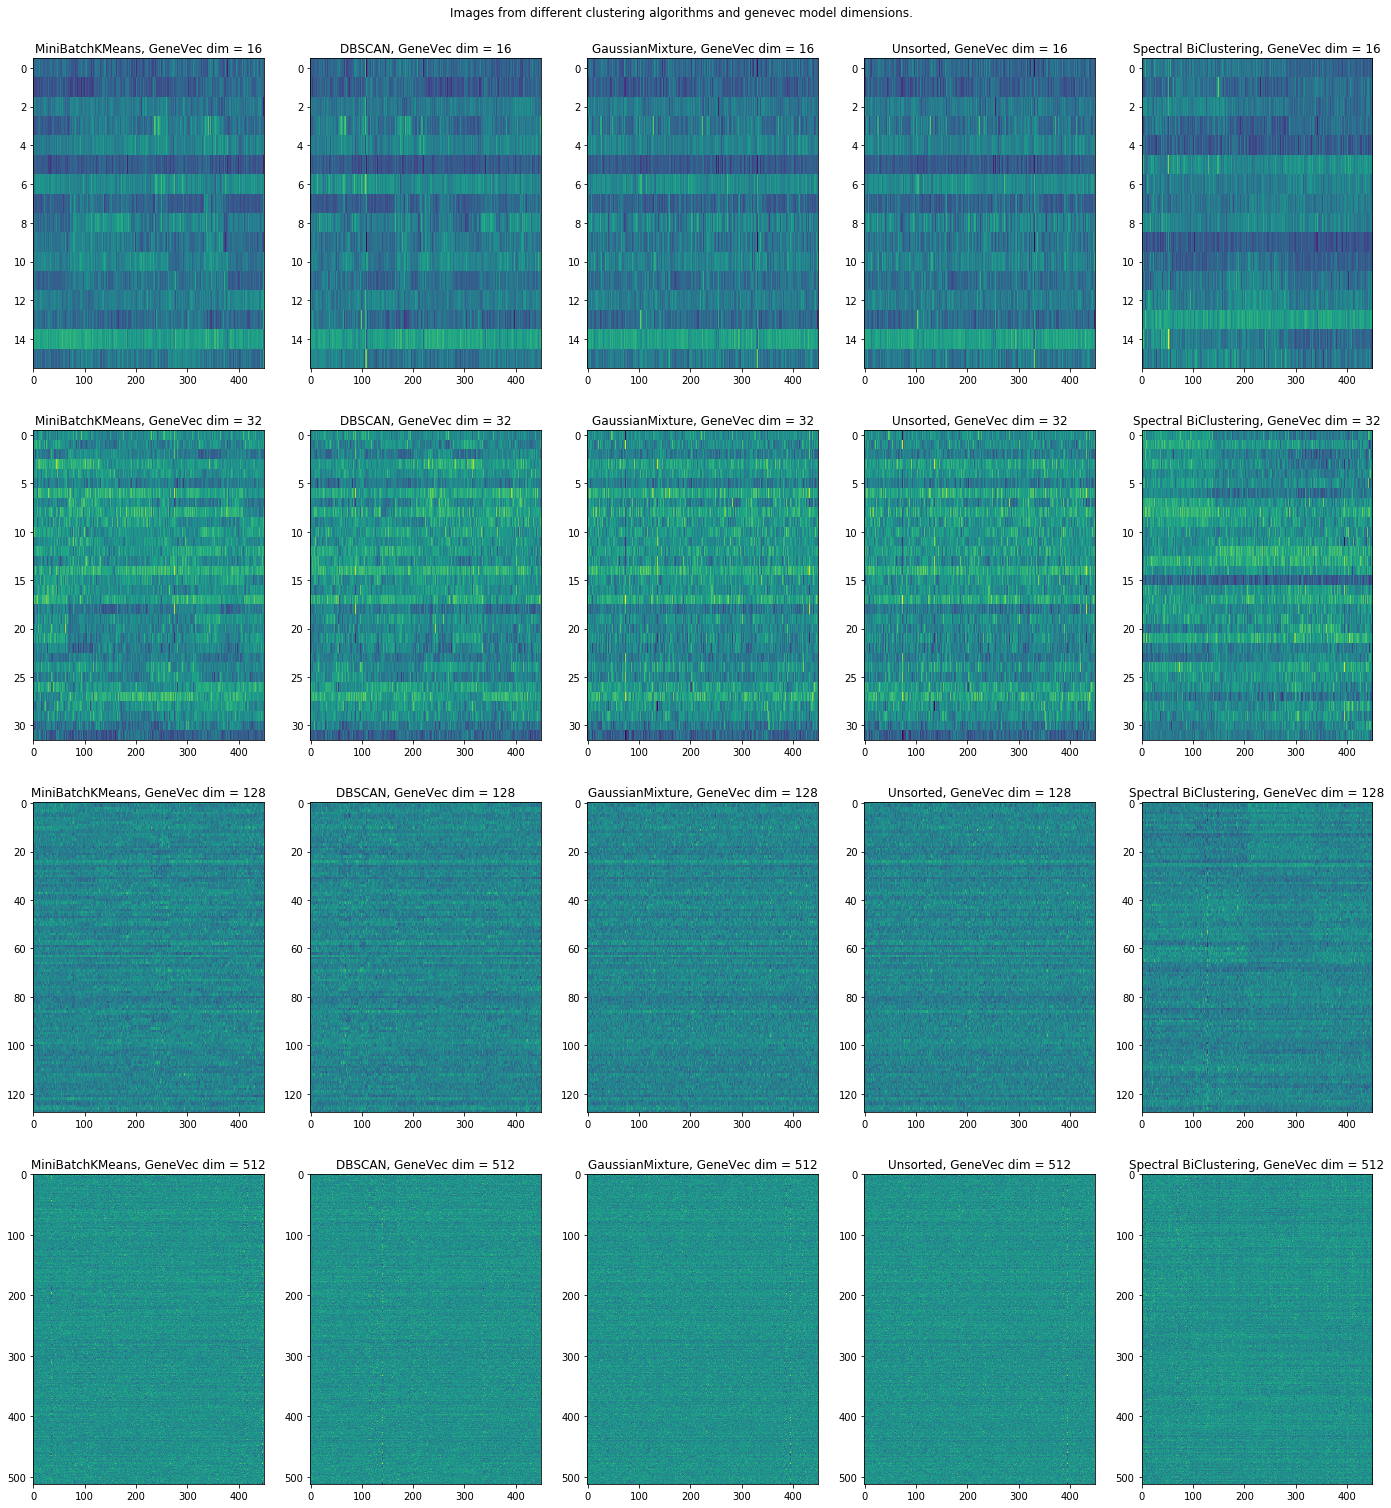

In [7]:
dims=[16, 32, 128, 512]
clustering_algos = ['MiniBatchKMeans',
                    'DBSCAN',
                    'GaussianMixture']

genes = gene_intersection(convert_to_onehot(df_X1), 
                          pd.DataFrame(wv.transpose(), columns=vocab))

vis_clustered_images(genes, dims, clustering_algos, n_clusters=50)

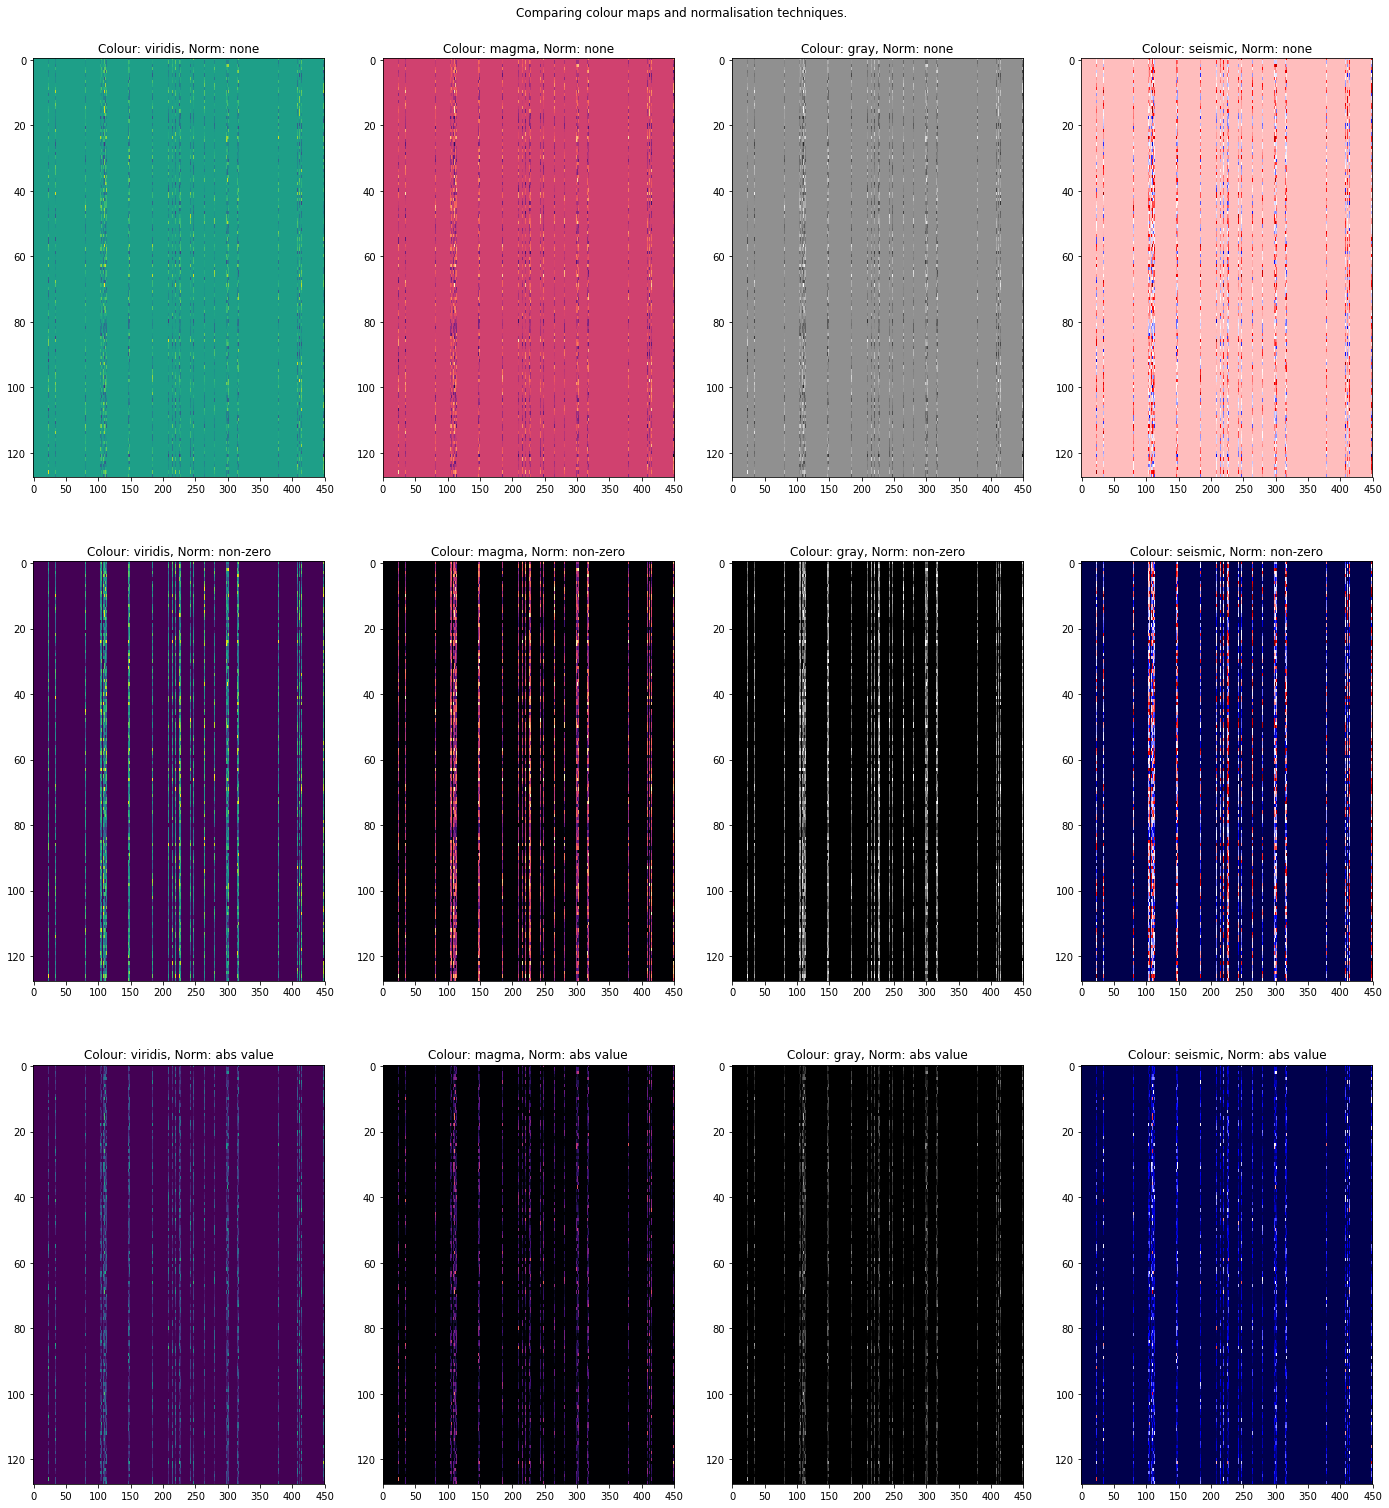

In [8]:
colours = ['viridis','magma','gray','seismic']
norms = ['none','non-zero','abs value']

# load data
filename = GENE2VEC_DIR + 'dim_{}/iter_10'.format(128)
wv, vocab = load_embeddings(filename)

# get gene subset
df_genevec = pd.DataFrame(wv.transpose(), columns=vocab)
df_somatic = convert_to_onehot(df_X1)

genes = gene_intersection(df_somatic, df_genevec)

# initialise algos on gene subset
X = df_genevec[genes].values.transpose()
algos = init_algos(X)
algos = tuple([algo for algo in algos if algo[0] in ['MiniBatchKMeans']])
y_preds = Parallel()(delayed(cluster_job)((name, algo, X)) for name, algo in algos)
y_pred = y_preds[0]

vis_image_norm_colours(df_genevec[genes], df_somatic[genes], y_pred, norms, colours)

### Experiments
- Visualise distribution of values in sample

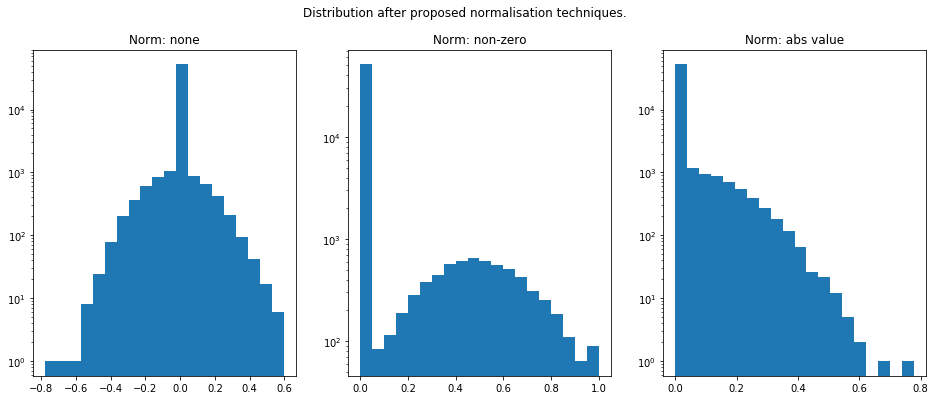

In [13]:
vis_norm_histogram(df_genevec[genes], df_somatic[genes], y_pred, norms)

---